## Preparação do ambiente

- Definição da sessão spark
- Conexão com o Drive

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 12.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=347b83e73606f32690483ef783ada7fce4edb76cbd8428c21cc065f27b1217a4
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
                    .master('local[*]')\
                    .appName('Challenge DataScience - 2 Ed')\
                    .getOrCreate()
spark

In [3]:
from google.colab import drive 
drive.mount('my-drive')

Mounted at my-drive


## Manipulações iniciais da base já tratada
  - A partir do dataset já inicialmente tratado a partir do conjunto de dados bruto fornecido no início do projeto, o objetivo será efetuar algumas manipulações básicas (essenciais para os métodos de Machine Learning) e iniciar a construção do modelo de regressão

In [4]:
# começo retomando a base de dados tratados construída anteriormente;
# comparo a base tratada fornecida pelos instrutores da alura com a base construída por mim
# para validação de resultados

df = spark.read.parquet(
    '/content/my-drive/MyDrive/Formações Alura/DataScience/Challenge-2ed/dados-e-arquivos-tratados/dataset-tratado/parquet'
)


In [5]:
df.show(5)

+--------------------+------------+------------+-----------+----------+---------+-------+------+---------+----+-----+--------------------+---------+----------+----------+----+-----+-----+
|                  id|tipo_anuncio|tipo_unidade|   tipo_uso|area_total|area_util|quartos|suites|banheiros|vaga|andar|     caracteristicas|   bairro|      zona|condominio|iptu| tipo|valor|
+--------------------+------------+------------+-----------+----------+---------+-------+------+---------+----+-----+--------------------+---------+----------+----------+----+-----+-----+
|d2e3a3aa-09b5-45a...|       Usado| Apartamento|Residencial|        43|       43|      2|  null|        1|   1|    3|[Academia, Churra...|Paciência|Zona Oeste|       245|null|Venda|15000|
|085bab2c-87ad-452...|       Usado| Apartamento|Residencial|        42|       42|      2|  null|        1|   1|    2|[Churrasqueira, P...|Paciência|Zona Oeste|         0|   0|Venda|15000|
|18d22cbe-1b86-476...|       Usado| Apartamento|Residencial|

In [6]:
df.count()

66348

In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- area_total: long (nullable = true)
 |-- area_util: long (nullable = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- andar: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: long (nullable = true)
 |-- iptu: long (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: long (nullable = true)



- De acordo com o Schema observado, as primeiras manipulações que estaremos interessados em fazer ocorrem com respeito aos datatypes de cada coluna.
  - As colunas "andar", "banheiros", "suites" e "quartos" estão registradas como LongInt. A princípio, para esses casos, apenas o IntegerType já é suficiente.

  - As colunas "area_util", "condominio", "iptu" e "valor", por outro lado, devem ficar registradas com o tipo DoubleType.

In [8]:
from pyspark.sql import functions as f 
from pyspark.sql.types import DoubleType, IntegerType

columns_to_set_DoubleType = ['area_util', 'condominio', 'iptu', 'valor']
columns_to_set_IntegerType = ['andar', 'banheiros', 'suites', 'quartos']

for c in columns_to_set_DoubleType:
  df = df.withColumn(c, f.col(c).cast(DoubleType()))

for c in columns_to_set_IntegerType:
  df = df.withColumn(c, f.col(c).cast(IntegerType()))

df.printSchema()

root
 |-- id: string (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- area_total: long (nullable = true)
 |-- area_util: double (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- vaga: long (nullable = true)
 |-- andar: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: double (nullable = true)



- Nos foi passada a informação de que alguns registros da coluna "caractersticas" são listas vazias. Devemos, portanto, eliminar esses registros do nosso conjunto de dados
  - A ideia será usar o método ".getItem(0)" para verificar quais registros têm esse primeiro valor nulo. Se ele for nulo, que dizer que a lista da linha correspondente é vazia


In [9]:
# contando quantos elementos contém listas vazias na coluna de características
df.select('*').where(f.isnull( f.col('caracteristicas').getItem(0) )).count()

12665

- Como são muitos dados (~10 000, mesma ordem de grandeza da quantidade total de registros) não podemos simplesmente descartá-los do nosso dataset; as demais colunas associadas a essas linhas podem conter informações relevantes para a construção posterior dos modelos de regressão.
- Para contornar esse problema, portanto, ajusto todas essas colunas com valor nulo (null)

In [10]:
# outra maneira de detectar esses caras utilizando a função "size" do pyspark.sql
df.select('*').filter( f.size( f.col('caracteristicas') ) == 0 ).count()

12665

In [11]:
# verificação dos arrays vazios (antes do tratamento)
df.select('caracteristicas').distinct().orderBy('caracteristicas', ascending=True).show(5)

+--------------------+
|     caracteristicas|
+--------------------+
|                  []|
|          [Academia]|
|[Academia, Animai...|
|[Academia, Animai...|
|[Academia, Animai...|
+--------------------+
only showing top 5 rows



In [12]:
# Faço a atualização desses dados utilizando o case when/else (f.when().otherwise, no caso do pyspark)

# detalhes da logica abaixo: quando o "len" da coluna caracteristicas for 0 (i.e., quando o array do campo correspondente for nulo),
# adicionamos o valor null (None para o dataframe spark no python); caso contrário, ajustamos o registro da própria coluna
df = df.withColumn('caracteristicas', f.when( f.size( f.col('caracteristicas') ) == 0, None ).otherwise( f.col('caracteristicas') ) )

# Poderíamos também estruturar esse mesmo update utilizando o método "getIem(0)" (verificando quando valor logo do primeiro index fosse nulo, o que 
# indicaria uma lista vazia)
# (utilizo uma sintaxe diferente no no argumento de aplicação das funções de tratamento apenas por prática)
#df = df.withColumn('caracteristicas', f.when( df['caracteristicas'].getItem(0).isNull(), None ).otherwise( df['caracteristicas'] ) )

In [13]:
#teste = df.select('*')
#teste = teste.withColumn('caracteristicas', f.when( f.col('caracteristicas').getItem(0).isNull(), 0 ).otherwise( f.col('caracteristicas') ) )

# o método "case when / else " (when / otherwise, no pyspark) não funcionou pois estamos colocando dois tipos de dados diferentes como saída:
# inteiro se a condição verificar verdadeira e array se a condição verificar falsa;
# a lógica está correta mas o spark não consegue efetuar esse tratamento

In [14]:
# validação da função de tratamento aplicada
df.select('caracteristicas').distinct().orderBy('caracteristicas', ascending=True).show(5)

+--------------------+
|     caracteristicas|
+--------------------+
|                null|
|          [Academia]|
|[Academia, Animai...|
|[Academia, Animai...|
|[Academia, Animai...|
+--------------------+
only showing top 5 rows



- Verifico a presença de registros nulos ao longo das colunas do nosso dataset e efetuo os tratamentos correspondentes

In [15]:
array_columns_to_check = df.columns

array_columns_to_check.remove('caracteristicas') 
# excluo a coluna de caracteristicas desse processo automatizado de contagem, mas sabemos já sabemos que ela contém um total de 
# 12 665 dados nulos (ajustes efetuados na célula anterior)

df.select([ f.count( f.when( f.isnull(col) | f.isnan(col) , 1 ) ).alias(col) for col in array_columns_to_check ] ).show()

+---+------------+------------+--------+----------+---------+-------+------+---------+----+-----+------+----+----------+----+----+-----+
| id|tipo_anuncio|tipo_unidade|tipo_uso|area_total|area_util|quartos|suites|banheiros|vaga|andar|bairro|zona|condominio|iptu|tipo|valor|
+---+------------+------------+--------+----------+---------+-------+------+---------+----+-----+------+----+----------+----+----+-----+
|  0|           0|           0|       0|      9186|        0|      0|  5544|        0|3008|    0|     0|   0|      2347|7155|   0|    0|
+---+------------+------------+--------+----------+---------+-------+------+---------+----+-----+------+----+----------+----+----+-----+



In [16]:
# verifico se a contagem anterior se refere somente aos dados null, ou se dados tipo nan contribuiram para o resultado final
df.select( [f.count( f.when( f.isnull(c), 1 ) ).alias(c) for c in array_columns_to_check] ) .show()

+---+------------+------------+--------+----------+---------+-------+------+---------+----+-----+------+----+----------+----+----+-----+
| id|tipo_anuncio|tipo_unidade|tipo_uso|area_total|area_util|quartos|suites|banheiros|vaga|andar|bairro|zona|condominio|iptu|tipo|valor|
+---+------------+------------+--------+----------+---------+-------+------+---------+----+-----+------+----+----------+----+----+-----+
|  0|           0|           0|       0|      9186|        0|      0|  5544|        0|3008|    0|     0|   0|      2347|7155|   0|    0|
+---+------------+------------+--------+----------+---------+-------+------+---------+----+-----+------+----+----------+----+----+-----+



In [17]:
# preenchimento dos dados nulos com valores 0
df = df.na.fill(0)

In [18]:
# efetuo novamente a contagem por fins de validação
df.select( [f.count( f.when( f.isnull(c), 1 ) ).alias(c) for c in array_columns_to_check] ) .show()

+---+------------+------------+--------+----------+---------+-------+------+---------+----+-----+------+----+----------+----+----+-----+
| id|tipo_anuncio|tipo_unidade|tipo_uso|area_total|area_util|quartos|suites|banheiros|vaga|andar|bairro|zona|condominio|iptu|tipo|valor|
+---+------------+------------+--------+----------+---------+-------+------+---------+----+-----+------+----+----------+----+----+-----+
|  0|           0|           0|       0|         0|        0|      0|     0|        0|   0|    0|     0|   0|         0|   0|   0|    0|
+---+------------+------------+--------+----------+---------+-------+------+---------+----+-----+------+----+----------+----+----+-----+



In [19]:
# verifico se os registros da coluna de caracteristicas foram corrigidos
df.select('caracteristicas').distinct().orderBy('caracteristicas', ascending=True).show(5)

+--------------------+
|     caracteristicas|
+--------------------+
|                null|
|          [Academia]|
|[Academia, Animai...|
|[Academia, Animai...|
|[Academia, Animai...|
+--------------------+
only showing top 5 rows



- Ao que podemos ver os registros nulos da coluna de caracteristicas não estão sendo corrigidos pelas nossas ferramentas usuais. Por enquanto isso não é um problema, pois a nossa ideia será quebrar os registros desses arrays em dummy variables no momento em que estivermos preparando o dataset para construção do modelo de regressão.

In [20]:
df.select('zona').distinct().collect()

[Row(zona='Zona Norte'),
 Row(zona='Zona Oeste'),
 Row(zona='Zona Central'),
 Row(zona='Zona Sul'),
 Row(zona='')]

In [21]:
# começo criando as dummy variables para a coluna de zonas
df_zona = df\
            .groupBy('id')\
            .pivot('zona')\
            .agg(f.lit(1))\
            .na\
            .fill(0)

df_zona.show(5)


+--------------------+---+------------+----------+----------+--------+
|                  id|   |Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+---+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|  0|           0|         0|         0|       1|
|02fba6ef-a691-442...|  0|           0|         0|         1|       0|
|fc03c1a9-8bbb-41a...|  0|           0|         1|         0|       0|
|3dd5d200-0a7f-43d...|  0|           0|         0|         0|       1|
|82707939-71bd-40c...|  0|           0|         0|         0|       1|
+--------------------+---+------------+----------+----------+--------+
only showing top 5 rows



In [22]:
df_zona = df_zona.drop('')
# o método ".drop" está sendo incluído para excluir uma coluna vazia que está sendo criada, correspondente a uma zona registrada como " '' "

df_zona.show(5)

+--------------------+------------+----------+----------+--------+
|                  id|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|           0|         0|         0|       1|
|02fba6ef-a691-442...|           0|         0|         1|       0|
|fc03c1a9-8bbb-41a...|           0|         1|         0|       0|
|3dd5d200-0a7f-43d...|           0|         0|         0|       1|
|82707939-71bd-40c...|           0|         0|         0|       1|
+--------------------+------------+----------+----------+--------+
only showing top 5 rows



- Agora que o dataframe auxiliar de dummy variables correspondente à coluna "zona" está feito, desenvolvo um tratamento da coluna "características" (formato array)

In [23]:
# defino um dataframe auxiliar incluindo somente as colunas que vamos trabalhar, com a finalidade de não sujar o nosso dataframe original
df_aux = df\
            .select('id', 'caracteristicas')

# incluo uma nova coluna nesse dataframe utilizando o método ".explode()", que basicamente funciona extraindo a os arrays da coluna de características
# e colocando-os numa mesma coluna para cada id correspondente.

# em outras palavras: se uma coluna com id "x" possuía inicialmente 5 valores dentro do array da coluna 'caracteristicas', então
# serão criadas 5 novas linhas com o id "x", uma para cada valor dentro do array da coluna 'caracteristicas'.

df_aux = df_aux.withColumn('caracteristicas_values', f.explode( f.col('caracteristicas') ))
df_aux.show(n = 10, truncate=False)

+------------------------------------+-------------------------------------------------------------------------------------------------------------------------------+----------------------+
|id                                  |caracteristicas                                                                                                                |caracteristicas_values|
+------------------------------------+-------------------------------------------------------------------------------------------------------------------------------+----------------------+
|d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3|[Academia, Churrasqueira, Playground, Salão de festas, Condomínio fechado, Portão eletrônico, Portaria 24h, Animais permitidos]|Academia              |
|d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3|[Academia, Churrasqueira, Playground, Salão de festas, Condomínio fechado, Portão eletrônico, Portaria 24h, Animais permitidos]|Churrasqueira         |
|d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3|[Academia, C

In [24]:
# agora efetuo um pivot da nova coluna criada e defino um novo dataframe auxiliar
df_caracteristicas = df_aux\
                          .groupBy('id')\
                          .pivot('caracteristicas_values')\
                          .agg(f.lit(1))\
                          .na\
                          .fill(0)

df_caracteristicas.show(10)

+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|fd96bbd5-d631-416...|       1|                 1|            1|                 1|       1|      1|         1|           1|                1|              1|
|bfffedfe-99e7-4ae...|       0|                 1|            1|                 1|       1|      0|         1|           0|                1|              1|
|fcb67af3-5601-415...|       1|                 1|            1|                 0|       0|      1|         1|           0|                0|              1|
|afecddff-f4cc-4ab...|       1|               

- Uma vez feitos esses tratamentos, junto tudo no nosso dataset inicial

In [25]:
df.count()

66348

In [26]:
df = df.join(other= df_zona , on= 'id', how= 'inner')
df = df.join(other= df_caracteristicas, on= 'id', how= 'inner')

df.show(10)

+--------------------+------------+------------+-----------+----------+---------+-------+------+---------+----+-----+--------------------+--------------------+----------+----------+------+-----+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|tipo_anuncio|tipo_unidade|   tipo_uso|area_total|area_util|quartos|suites|banheiros|vaga|andar|     caracteristicas|              bairro|      zona|condominio|  iptu| tipo|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+------------+------------+-----------+----------+---------+-------+------+---------+----+-----+--------------------+--------------------+----------+----------+------+-----+---------+------------+----------+--

In [27]:
df.count()

53683

- Podemos ver que estamos perdendo cerca de ~ 10 000 dados após os joins de cruzamento com os dataframes auxiliares criados. Isso está ocorrendo devido aos registros nulos que temos no nosso dataframe de caracteristicas. Como não há características para "pivotar", essas linhas são simplesmente apagadas do dataframe.

In [28]:
#verificar esses codigos depois

# uma maneira de testar essa hipótese, é contar a quantidade de registros antes e após a aplicação do argumento "explode" e pivot
teste = spark.read.parquet(
    '/content/my-drive/MyDrive/Formações Alura/DataScience/Challenge-2ed/dados-e-arquivos-tratados/dataset-tratado/parquet'
)
teste = teste.withColumn('caracteristicas', f.when( f.size( f.col('caracteristicas') ) == 0, None ).otherwise( f.col('caracteristicas') ) )


qtd_total_inicial = teste.count()
qtd_nulos_inicial = teste.filter( f.col('caracteristicas').isNull() ).count()

# agora aplico os métodos explode/pivot na coluna da características
# (a expectativa é que o explode ainda mantenha os registros nulos, mas que eles sumam durante a aplicação do pivot)
teste = teste.withColumn('caracteristicas_values', f.explode( f.col('caracteristicas') ))

qtd_nulos_logo_apos_explode = teste.filter( f.col('caracteristicas').isNull() ).count()

teste_aux = teste.groupBy('id').pivot('caracteristicas_values').agg(f.lit(1)).na.fill(0)
qtd_dados_tabela_pivot = teste_aux.count()

teste = teste.join(other= teste_aux, on= 'id', how= 'inner')
qtd_total_final = teste.count()
qtd_nulos_final = teste.filter( f.col('caracteristicas').isNull() ).count()

print('Quantidade inicial total de dados no dataset: {}'.format(qtd_total_inicial))
print('Quantidade inicial de nulos ("caracteristicas") no dataset: {}'.format(qtd_nulos_inicial))
#print('Quantidade de nulos ("caracteristicas") após o método "explode": {}'.format(qtd_nulos_logo_apos_explode))
print('Quantidade total de dados na tabela pivot: {}'.format(qtd_dados_tabela_pivot))
#print('Quantidade total de dados após o join: {}'.format(qtd_total_final))
print('Quantidade total de nulos ("caracteristicas") após o join: {}'.format(qtd_nulos_final))

Quantidade inicial total de dados no dataset: 66348
Quantidade inicial de nulos ("caracteristicas") no dataset: 12665
Quantidade total de dados na tabela pivot: 53683
Quantidade total de nulos ("caracteristicas") após o join: 0


- Depois de efetuados esses tratamentos, começo o processo de seleção / definição das features que serão aplicadas no modelo. 
  - As colunas "tipo_anuncio", "tipo_unidade", "tipo_uso" e "tipo" possuem apenas um único registro, pois já efetuamos filtros dos valores dessas colunas nos tratamentos iniciais da base de dados da semana 1. Elas podem ser descartadas (serão irrelevantes para o modelo)
  - As colunas "area_total" e "area_util" são dois casos peculiares. A princípio o ideal seria selecionarmos todas as features de interesse e montar um mapa de calor de correlação. Mas essas duas colunas são claramente correlacionadas. Não faz sentido continuarmos carregando as duas. Apesar da forte correlação entre ambas e muitos dos registros incluídos na base serem iguais nessas duas colunas, muito provavelmente a "area_total" tem um impacto maior na definição do preço do imóvel. Isso precisaria ser discutido com as demais equipes do projeto (não caberia à equipe de Data Science e Analytics tomar essa decisão), mas pensemos por um momento: mesmo que a área útil de uma residência seja pequena, se o terreno for grande a expectativa é que, de fato, o valor do imóvel aumente.
    - A conclusão, portanto, seria deixaremos de continuar carregando a coluna "area_util" e efetuaremos um filtro para excluir aqueles registros de "area_total" com valor 0. Entretanto essa coluna possui muitos valores 0, tal como pode ser observado a seguir. De fato, se retrocedermos o nosso código, veremos que ela foi uma das colunas atingidas pelo nosso método ".na.fill(0)" para preenchimento de valores nulos. Por uma questão de ganho de informação e maior confiabilidade dos resultados, excluiremos a coluna "area_total" e seguiremos trabalhando somente com a coluna "area_util".

- As informações da coluna "características" já foram ajustadas, então não há necessidade de continuar com essa coluna também, bem como as colunas "zona" e "bairro" (cujas informações já estão armazenadas nos campos de zona)

- A coluna "id" também não será de grande relevância para a construção do nosso modelo

In [29]:
df.select('area_total', 'area_util', 'valor').limit(30).show()

+----------+---------+--------+
|area_total|area_util|   valor|
+----------+---------+--------+
|        43|     43.0| 22999.0|
|        47|     47.0|138000.0|
|     17089|     45.0|140000.0|
|        48|     48.0|150000.0|
|         0|     55.0|160000.0|
|        70|     70.0|159000.0|
|        50|     48.0|170000.0|
|        40|     40.0|189000.0|
|        50|     50.0|185000.0|
|        45|     45.0|199000.0|
|        48|     48.0|205933.0|
|        44|     44.0|206000.0|
|        55|     55.0|219130.0|
|        60|     60.0|230000.0|
|        51|     51.0|239000.0|
|        50|     50.0|260000.0|
|        96|     96.0|260000.0|
|        48|     48.0|251800.0|
|        55|     55.0|260000.0|
|        48|     48.0|270000.0|
+----------+---------+--------+
only showing top 20 rows



In [30]:
# então, aplico os drops das colunas irrelevantes para os nossos modelos
df = df.drop('tipo_unidade', 'tipo_anuncio', 'tipo_uso', 'area_total', 'tipo', 'bairro', 'zona', 'caracteristicas', 'id')

In [31]:
df.show(5)

+---------+-------+------+---------+----+-----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|area_util|quartos|suites|banheiros|vaga|andar|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+---------+-------+------+---------+----+-----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|    410.0|      4|     1|        3|   1|    0|    3300.0|5780.0|4600000.0|           0|         0|         0|       1|       0|                 0|            0|                 0|       1|      0|         0|           0|           

- Uma vez feitos os principais ajustes associados às colunas relevantes para construção do modelo de Machine Learning, podemos fazer (antes da definição das colunas de features / label) uma análise de correlação. Ela serve para avaliar quais variáveis estão mais (ou menos) correlacionadas e, assim efetuar exclusões a fim de evitar o fenômeno da multicolinearidade. 
  - Lembrando que a multicolinearidade está associada ao cálculo dos parâmetros de qualidade dos modelos de regressão. Caso o fenômeno esteja presente no dataset, serão obtidos parâmetros incorretos / inconsistentes, os quais levam, consequentemente, a análises equivocadas
  - As colunas "area_total" e "area_util" são dois exemplos de colunas extremamente correlacionadas. No presente momento uma delas foi removida devido a outras questões, mas se ambas estivessem presentes no dataset ainda, a análise de correlação iria claramente sugerir a remoção de alguma elas.

In [32]:
df.show(10)

+---------+-------+------+---------+----+-----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|area_util|quartos|suites|banheiros|vaga|andar|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+---------+-------+------+---------+----+-----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|    410.0|      4|     1|        3|   1|    0|    3300.0|5780.0|4600000.0|           0|         0|         0|       1|       0|                 0|            0|                 0|       1|      0|         0|           0|           

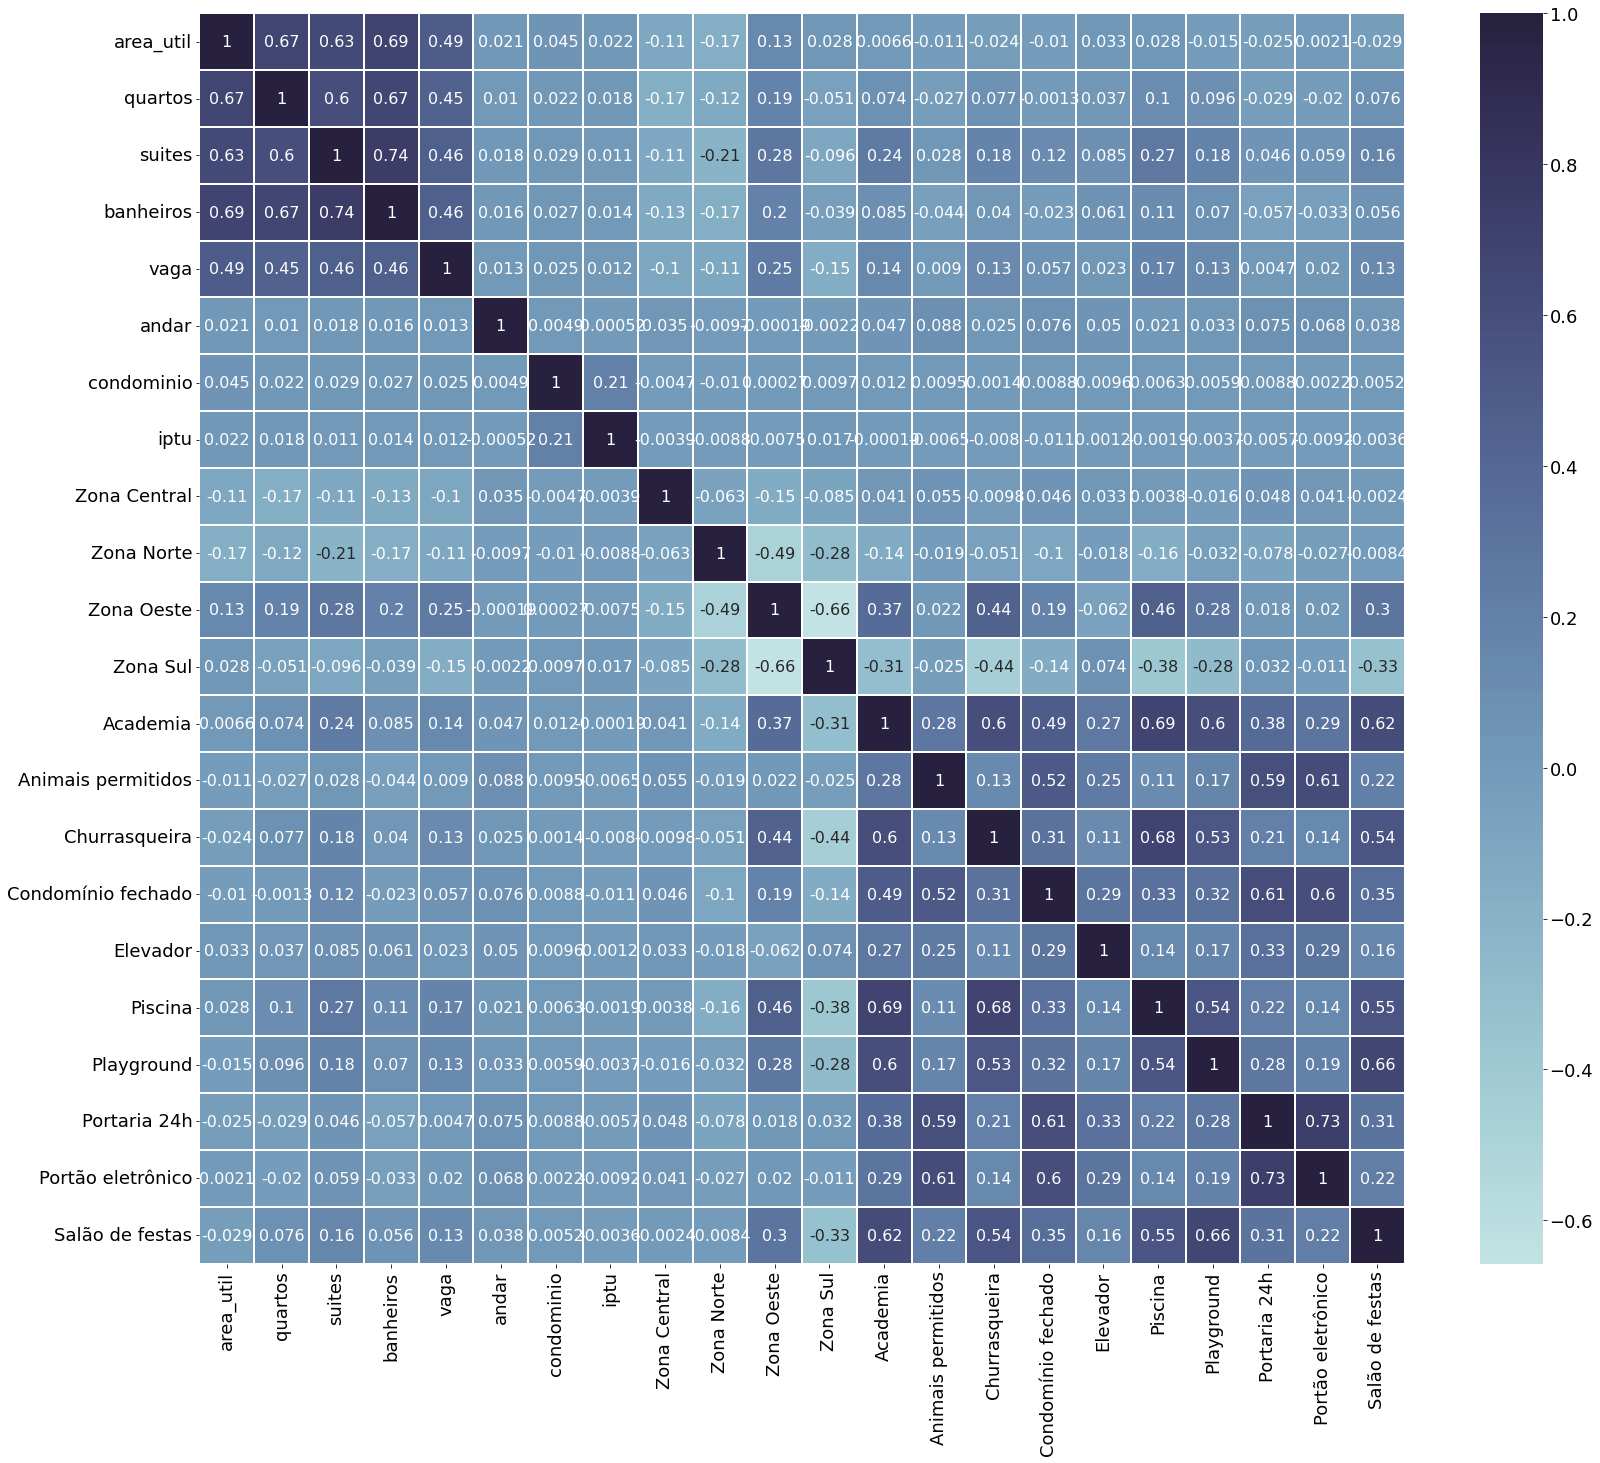

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_be_features = df.columns 
columns_to_be_features.remove('valor') 
# a análise de correlação deve encolver somente as colunas com potencial de se transformarem em features;
# não faz sentido incluirmos a coluna "valor" (que será nossa label) nessa análise


blue_style = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True) # definição da paleta de cores 
df_corr = df.select(columns_to_be_features).toPandas().corr()
# o seaborn não tem integração com dataframes spark, então temos que fazer a conversão para Pandas
# antes de aplicar o método de correlação e inserir na função de plot

ax = plt.figure(figsize=(27,23))

ax = sns.heatmap(
    data = df_corr,
    cmap = blue_style,
    annot = True,
    annot_kws = {"fontsize":16},
    linewidths = 0.3
)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Definindo o objeto matplotlib.colorbar.Colorbar
cbar = ax.collections[0].colorbar
# Ajustando a fontsize
cbar.ax.tick_params(labelsize=18)

plt.savefig('my-drive/MyDrive/Formações Alura/DataScience/Challenge-2ed/correlation_analysis.png', dpi = 300)

- Podemos notar que existem, de fato, algumas variáveis com correlação relativamente forte (~0.7), mas nada muito grave ainda. O perigo começar a ficar grande mesmo para valores acima de 0.8.
  - Se estivéssemos mais receosos com relação ao fenômeno da multicolinearidade, poderíamos já tratar os casos de correlação na faixa de ~0.7. Nesse caso, algumas colunas (features) interessantes de serem removidas seriam:
    - "banheiros" e "quartos" (fortemente correlacionados com "suites", o que faz sentido; quanto mais suites, mais quartos e banheiros);
    - "portaria 24h", "piscina", "salao de festas" (fortemente correlacionados com outras características de lazer da moradia, tais como "churrasqueira", "academia", "playground", etc);


- Entretanto, remover colunas significa remover também informações. Então, nesse ponto do projeto a melhor conclusão seria a seguinte: apesar dos valores de correlação indicarem sim algumas tendências esperadas (tais como aquelas apontadas nos parágrafos anteriores), como nenhum deles atinge um patamar relativamente perigoso, iremos carregar as colunas ao longo dos modelos. Caso, futuramente, seja observada a necessidade de rever os modelos por conta de inconsistências ou falta de qualidade dos ajustes, retornamos aqui e reavaliamos o papel das correlações. 


## Construindo e estudando os modelos de Machine Learning
- Nessa seção estudaremos os 3 principais tipos de modelos de regressão para bases de dados tratadas (Regressão Linear, Árvore de Decisão e Random Forest) com a finalidade de verificar qual deles melhor se adequa à nossa base de dados

### 0) Definição do dataset de features/label e do conjunto de teste/treino

In [34]:
df.show(10)

+---------+-------+------+---------+----+-----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|area_util|quartos|suites|banheiros|vaga|andar|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+---------+-------+------+---------+----+-----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|    410.0|      4|     1|        3|   1|    0|    3300.0|5780.0|4600000.0|           0|         0|         0|       1|       0|                 0|            0|                 0|       1|      0|         0|           0|           

In [35]:
# Começo a definição das nossas features e a transformação do dataframe
from pyspark.ml.feature import VectorAssembler

X = [col for col in df.columns if col not in ['valor']]
# seleciono todas as colunas de interesse do dataframe (irrelevantes já foram removidas),
# com exceção da coluna de valor (que será nossa label, e representa justamente os valores que queremos prever)

vec_ass = VectorAssembler(inputCols= X, outputCol= 'features') # classe de assembling do vetor de features (transformadora; não precisa de fit)

df = vec_ass.transform(df) # dataframe completo tratado
df = df.withColumnRenamed('valor', 'label') # modificação do nome da coluna que será nossa label

df.show(10, truncate=False)

+---------+-------+------+---------+----+-----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+-------------------------------------------------------------------------------------------------+
|area_util|quartos|suites|banheiros|vaga|andar|condominio|iptu  |label    |Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|features                                                                                         |
+---------+-------+------+---------+----+-----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+-------------------------------------

In [36]:
df.write.parquet(
    path='/content/my-drive/MyDrive/Formações Alura/DataScience/Challenge-2ed/dados-e-arquivos-tratados/dataset_tratado_para_ML_parquet',
    mode='overwrite'
)

In [37]:
df_ML = df.select('features', 'label') # dataframe contendo somente a coluna de features / labels (além do identificador id)

In [38]:
df_ML.show(10, truncate=False)

+-------------------------------------------------------------------------------------------------+---------+
|features                                                                                         |label    |
+-------------------------------------------------------------------------------------------------+---------+
|(22,[0,1,2,3,4,6,7,11,16],[410.0,4.0,1.0,3.0,1.0,3300.0,5780.0,1.0,1.0])                         |4600000.0|
|(22,[0,1,3,4,5,6,7,9,13,16,20,21],[50.0,1.0,1.0,1.0,1.0,500.0,600.0,1.0,1.0,1.0,1.0,1.0])        |360000.0 |
|(22,[0,1,2,3,4,10,14,16,17],[148.0,4.0,2.0,4.0,2.0,1.0,1.0,1.0,1.0])                             |1200000.0|
|(22,[0,1,3,6,7,11,16],[104.0,2.0,1.0,1010.0,272.0,1.0,1.0])                                      |750000.0 |
|(22,[0,1,3,4,6,7,11,16],[71.0,2.0,2.0,1.0,1312.0,360.0,1.0,1.0])                                 |1025000.0|
|[115.0,3.0,0.0,2.0,0.0,3.0,1904.0,3831.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0]|1100000.0|
|[65.0,2.0

In [39]:
treino, teste = df_ML.randomSplit(weights=[0.7, 0.3], seed = 101)

In [40]:
treino.count()

37594

In [41]:
teste.count()

16089

### 1) Regressão Linear

In [42]:
from pyspark.ml.regression import LinearRegression

# defino a classe de regressão
lr = LinearRegression(featuresCol='features', labelCol='label', predictionCol='prediction')
# por enquanto, mantenho as demais configurações dentro do padrão default da biblioteca

lr_model = lr.fit(treino) # faço um treinamento
lr_model_results = lr_model.transform(teste) # aplico o modelo treinado ao conjunto de teste

lr_model_results.show(n=10, truncate=False)

+-------------------------------------------------------------------------------------------------+--------+------------------+
|features                                                                                         |label   |prediction        |
+-------------------------------------------------------------------------------------------------+--------+------------------+
|(22,[0,1,2,3,4,5,6,7,9,13],[81.0,3.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0])                           |816000.0|814248.7150136557 |
|(22,[0,1,2,3,4,5,6,7,9,13],[90.0,3.0,1.0,3.0,1.0,5.0,1000.0,1521.0,1.0,1.0])                     |650000.0|636167.5362653834 |
|(22,[0,1,2,3,4,5,6,7,9,13,14,16,20],[102.0,2.0,1.0,3.0,1.0,6.0,950.0,107.0,1.0,1.0,1.0,1.0,1.0]) |690000.0|559178.6622233662 |
|(22,[0,1,2,3,4,5,6,7,9,13,14,16,21],[160.0,4.0,2.0,4.0,3.0,2.0,550.0,1146.0,1.0,1.0,1.0,1.0,1.0])|897000.0|1509259.9922863322|
|(22,[0,1,2,3,4,5,6,7,9,13,15,16],[94.0,3.0,1.0,2.0,1.0,2.0,420.0,80.0,1.0,1.0,1.0,1.0])          |32000

In [43]:
# verifico os parâmetros de qualidade do ajuste efetuado
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator()

r2 = evaluator.evaluate(lr_model_results, {evaluator.metricName:'r2'})
rmse = evaluator.evaluate(lr_model_results, {evaluator.metricName:'rmse'})

print('PARÂMETROS DE QUALIDADE DO MODELO DE REGRESSÃO LINEAR')
print('='*30)
print('r2: {:.5f}'.format(r2))
print('rmse: {:.5f}'.format(rmse))

PARÂMETROS DE QUALIDADE DO MODELO DE REGRESSÃO LINEAR
r2: 0.68547
rmse: 849030.86551


- Obtivemos uma taxa de acerto de aproximadamente 68% dos dados de teste. A métrica rmse ficou relativamente alta, mas seria legal comparar com a saída de outros modelos antes de tirar maiores conclusões.

### 2) Árvore de Decisão

In [44]:
from pyspark.ml.regression import DecisionTreeRegressor

# definição da classe de regressão associada à árvore de decisão
dtc = DecisionTreeRegressor(featuresCol='features', labelCol='label', predictionCol='prediction')
dtc_model = dtc.fit(treino) # treinamento do modelo 

dtc_model_results = dtc_model.transform(teste) # aplicação do modelo construído ao conjunto teste (inédito)

dtc_model_results.show(10, truncate=False)

+-------------------------------------------------------------------------------------------------+--------+------------------+
|features                                                                                         |label   |prediction        |
+-------------------------------------------------------------------------------------------------+--------+------------------+
|(22,[0,1,2,3,4,5,6,7,9,13],[81.0,3.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0])                           |816000.0|595949.8584916391 |
|(22,[0,1,2,3,4,5,6,7,9,13],[90.0,3.0,1.0,3.0,1.0,5.0,1000.0,1521.0,1.0,1.0])                     |650000.0|595949.8584916391 |
|(22,[0,1,2,3,4,5,6,7,9,13,14,16,20],[102.0,2.0,1.0,3.0,1.0,6.0,950.0,107.0,1.0,1.0,1.0,1.0,1.0]) |690000.0|980259.9178437591 |
|(22,[0,1,2,3,4,5,6,7,9,13,14,16,21],[160.0,4.0,2.0,4.0,3.0,2.0,550.0,1146.0,1.0,1.0,1.0,1.0,1.0])|897000.0|1397127.7221780603|
|(22,[0,1,2,3,4,5,6,7,9,13,15,16],[94.0,3.0,1.0,2.0,1.0,2.0,420.0,80.0,1.0,1.0,1.0,1.0])          |32000

In [45]:
# faço uma avaliação das métricas de qualidade associadas ao modelo da árvore de decisão
from pyspark.ml.evaluation import RegressionEvaluator

# defino as classes de avaliação de uma maneira diferente (apenas por fins de aprendizado)
evaluator_r2 = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2')
evaluator_rmse = RegressionEvaluator(metricName = 'rmse')

r2 = evaluator_r2.evaluate(dtc_model_results)
rmse = evaluator_rmse.evaluate(dtc_model_results)

print('r2: {:.5f}'.format(r2))
print('rmse: {:.5f}'.format(rmse))

r2: 0.73935
rmse: 772897.76852


- Já pudemos observar uma melhora em ambas as métricas! O r2 passou de ~0.68 para ~0.74, enquanto o rmse teve seu módulo reduzido também. Podemos ainda verificar um modelo ainda mais eficaz nessa modelagem: o random forest (que consiste em efetuar diversas decision-trees para ensembles de dados retirados do conjunto de treino fornecido e, no fim, definir como estimativa de previsão as médias dos resultados de cada decision-tree).

### 3) Random Forest

In [46]:
from pyspark.ml.regression import RandomForestRegressor

# definição da classe de regressão
rfr = RandomForestRegressor(featuresCol='features', labelCol='label', predictionCol='prediction', seed=101)

rfr_model = rfr.fit(treino) # efetuo o treinamento do algoritmo de regressão
rfr_model_results = rfr_model.transform(teste) # aplico o modelo construído aos dados de teste (inéditos)

rfr_model_results.show(10,truncate=False)

+-------------------------------------------------------------------------------------------------+--------+-----------------+
|features                                                                                         |label   |prediction       |
+-------------------------------------------------------------------------------------------------+--------+-----------------+
|(22,[0,1,2,3,4,5,6,7,9,13],[81.0,3.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0])                           |816000.0|621916.1427504187|
|(22,[0,1,2,3,4,5,6,7,9,13],[90.0,3.0,1.0,3.0,1.0,5.0,1000.0,1521.0,1.0,1.0])                     |650000.0|668826.5676351101|
|(22,[0,1,2,3,4,5,6,7,9,13,14,16,20],[102.0,2.0,1.0,3.0,1.0,6.0,950.0,107.0,1.0,1.0,1.0,1.0,1.0]) |690000.0|767314.019319473 |
|(22,[0,1,2,3,4,5,6,7,9,13,14,16,21],[160.0,4.0,2.0,4.0,3.0,2.0,550.0,1146.0,1.0,1.0,1.0,1.0,1.0])|897000.0|1500581.068068759|
|(22,[0,1,2,3,4,5,6,7,9,13,15,16],[94.0,3.0,1.0,2.0,1.0,2.0,420.0,80.0,1.0,1.0,1.0,1.0])          |320000.0|641

In [47]:
# faço uma avaliação das métricas de qualidade
from pyspark.ml.evaluation import RegressionEvaluator

# podemos também definir os algoritmos de avaliação assim;
# uma vez que as colunas de entrada já estão ajustadas no padrão default
# aceito pelas classes, a inclusão dos nomes respectivos (ou não) torna-se opcional
evaluator_r2 = RegressionEvaluator(metricName='r2') 
evaluator_rmse = RegressionEvaluator(metricName='rmse') 

r2 = evaluator_r2.evaluate(rfr_model_results)
rmse = evaluator_rmse.evaluate(rfr_model_results) 

print('r2: {:.5f}'.format(r2))
print('rmse: {:.5f}'.format(rmse))

r2: 0.76936
rmse: 727038.55560


###4) Gradient-Boosted-Tree

In [48]:
from pyspark.ml.regression import GBTRegressor

# definição da classe de regressão
gbt = GBTRegressor(featuresCol='features', labelCol='label', predictionCol='prediction', seed=101)

gbt_model = gbt.fit(treino) # treinamento do algoritmo
gbt_model_results = gbt_model.transform(teste) # aplicação do modelo construído aos dados de teste (inéditos)

gbt_model_results.show(10,truncate=False)

+-------------------------------------------------------------------------------------------------+--------+------------------+
|features                                                                                         |label   |prediction        |
+-------------------------------------------------------------------------------------------------+--------+------------------+
|(22,[0,1,2,3,4,5,6,7,9,13],[81.0,3.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0])                           |816000.0|833803.9520903045 |
|(22,[0,1,2,3,4,5,6,7,9,13],[90.0,3.0,1.0,3.0,1.0,5.0,1000.0,1521.0,1.0,1.0])                     |650000.0|559257.6459293178 |
|(22,[0,1,2,3,4,5,6,7,9,13,14,16,20],[102.0,2.0,1.0,3.0,1.0,6.0,950.0,107.0,1.0,1.0,1.0,1.0,1.0]) |690000.0|653714.8397409278 |
|(22,[0,1,2,3,4,5,6,7,9,13,14,16,21],[160.0,4.0,2.0,4.0,3.0,2.0,550.0,1146.0,1.0,1.0,1.0,1.0,1.0])|897000.0|1174856.8522326187|
|(22,[0,1,2,3,4,5,6,7,9,13,15,16],[94.0,3.0,1.0,2.0,1.0,2.0,420.0,80.0,1.0,1.0,1.0,1.0])          |32000

In [49]:
# verifico as métricas de qualidade
from pyspark.ml.evaluation import RegressionEvaluator 

evaluator_r2 = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2')
evaluator_rmse = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse')

r2 = evaluator_r2.evaluate(gbt_model_results)
rmse = evaluator_rmse.evaluate(gbt_model_results)

print('r2: {:.5f}'.format(r2))
print('rmse: {:.5f}'.format(rmse))

r2: 0.80477
rmse: 668917.14945


### 5) Definição do melhor modelo e implementação de otimização

- Após uma avaliação das sequências de código anteriores, estima-se que o melhor modelo para se levar adiante é o GBT (Gradient Boosted Tree). Ao avaliar a documentação e as motivações, faz sentido que este seja, de fato, o melhor modelo, já que o seu algoritmo base funciona com processos de minimização da função custo (MMQ, basicamente).

- Contudo, é muito importante tomar cuidado com os parâmetros fornecidos. Os principais associados ao algoritmo regressor (normalmente chamados "hyperparameters"), são o learning-rate e o número de iterações (árvores de decisão refinadas).
  - O learning-rate define "o quão rápido" o algoritmo tenderá a alcançar o modelo que minimiza a função custo. Supondo que $F$ seja um modelo estimado pelo algoritmo, que $h$ seja uma "perturbação corretiva", $y$ o valor verdadeiro da label em estudo e $x$ o conjunto de features que correspondem à label anterior, o coeficiente $\alpha$ ( $0 \leq \alpha \leq 1$) correspode ao learning-rate
$$
F(x) + \alpha \cdot h(x) = y
$$ 

  - Quanto maior esse coeficiente, mais rápido o algoritmo tende ao modelo que minimiza a função custo (MMQ). Contudo, como nesse caso a aproximação é muito grosseira, pode ser que o modelo em questão nunca seja alcançado. Quanto menor o coeficiente, mais lentamente o algoritmo tente ao modelo minimizador (mas para isso é necessário implementar no algoritmo uma quantidade maior de iterações).

  - A quantidade de iterações (número de árvores de decisão ajustadas) depende diretamente do valor escolhido para o learning-rate, e é por isso que esses dois parâmetros andam juntos. Caso o learning-rate seja muito grande (aproximações grosseiras), uma quantidade pequena de iterações já deve ser suficiente para alcançar um modelo de regressão razoavelmente bom. Contudo, caso o learning-rate seja muito pequeno (aproximações refinadas), muitas iterações deverão ser feitas pelo algoritmo até que seja atingido o modelo minimizador da função custo.

- Apesar do GBT ser muito eficiente (e, em geral, melhor que o random forest), deve-se tomar cuidado para não fornecer os parâmetros necessários de maneira incorreta e acabar, assim, provocando um "overfit" do modelo.

In [51]:
# para desenvolver a otimização do modelo GBT é necessário definir um grid dos parâmetros que deverão ser testados pelo algoritmo
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')
gbt = GBTRegressor(featuresCol='features', labelCol='label', predictionCol='prediction', seed=101)
# para a classe gbt do spark o parametro "learning rate" é chamado "step size"

grid = ParamGridBuilder()\
          .addGrid(gbt.stepSize, [0.2, 0.4, 0.6])\
          .addGrid(gbt.maxIter, [20, 15, 10])\
          .addGrid(gbt.maxDepth, [5, 7, 10])\
          .build()

# lógica do código acima: estamos tentando encontrar a melhor combinação dos 3 principais parâmetros associados ao GBT:
  # 1) stepSize (learning rate)
  # 2) maxIter (numero maximo de iterações)
  # 3) maxDepth (profundidade, i.e., quantidade de nós de partição)

  # Quanto menor o stepSize, maior deve ser a quantidade de árvores de decisão e, portanto,
  # para evitar ativar uma quantidade absurda de processamento, definimos profundidades mais rasas;

  # o mesmo raciocínio se aplica à medida que o learning rate auemnta: o número de árvores de decisão pode ser menor e,
  # portanto, para manter / alcançar uma quantidade razoável de informação no modelo, aumentamos a profundidade
  # das árvores do algoritmo

gbt_cv = CrossValidator(
    estimator = gbt,
    estimatorParamMaps = grid,
    evaluator = evaluator,
    numFolds = 2,
    seed = 101
)

gbt_cv_model = gbt_cv.fit(treino) # construo o modelo efetuando o ajuste do conjunto de dados de treino
gbt_cv_model_results = gbt_cv_model.transform(teste) # aplico o modelo construído aos dados de teste, executando uma transformação

gbt_cv_model_results.show(10)

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(22,[0,1,2,3,4,5,...|816000.0| 845299.6779883668|
|(22,[0,1,2,3,4,5,...|650000.0| 594179.4520330665|
|(22,[0,1,2,3,4,5,...|690000.0| 593462.3090398721|
|(22,[0,1,2,3,4,5,...|897000.0|1111758.2626298938|
|(22,[0,1,2,3,4,5,...|320000.0| 549802.6014888731|
|(22,[0,1,2,3,4,5,...|570000.0| 653384.8604696266|
|(22,[0,1,2,3,4,5,...|449000.0| 286931.2269068332|
|(22,[0,1,2,3,4,5,...|640000.0| 542243.3967239172|
|(22,[0,1,2,3,4,5,...|850000.0| 666611.2609552873|
|(22,[0,1,2,3,4,5,...|619000.0| 596896.6985569639|
+--------------------+--------+------------------+
only showing top 10 rows



In [53]:
# faço uma avaliação das métricas de qualidade
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_r2 = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2')
evaluator_rmse = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse')

r2 = evaluator_r2.evaluate(gbt_cv_model_results)
rmse = evaluator_rmse.evaluate(gbt_cv_model_results)

print('r2: {:.5f}'.format(r2))
print('rmse: {:.5f}'.format(rmse))

r2: 0.81420
rmse: 652553.98597


- Obtivemos uma melhoria modesta de apenas 1% no parâmetro r2. O parâmetro rmse também teve uma redução, mas não foi muito grande. 

- No fim das contas, então, optaremos por ficar com esse modelo levemente aperfeiçoado. A princípio o ideal seria explorar um número maior de folds e do grid de parâmetros, mas faltou poder computacional (tempos de execução muito longos mesmo utilizando o método de cross validation).

In [58]:
best_maxIter = gbt_cv_model.bestModel.getMaxIter()
best_maxDepth = gbt_cv_model.bestModel.getMaxDepth()
best_stepSize = gbt_cv_model.bestModel.getStepSize()

aux_dict = (  ('Número máximo de iterações (maxIter)', best_maxIter)
            , ('Quantidade total de nós decisão (maxDepth)', best_maxDepth)
            , ('Learning rate (stepSize)', best_stepSize) 
           )

for param_description, param_value in aux_dict:
  print('{} : {}'.format(param_description, param_value))

Número máximo de iterações (maxIter) : 20
Quantidade total de nós decisão (maxDepth) : 5
Learning rate (stepSize) : 0.2


In [60]:
# Agora que vamos definir o nosso melhor modelo de regressão, dado que já avaliamos
# os diferentes algoritmos possíveis e testamos cada um deles no que se refere às métricas de qualidade,
# podemos construir um modelo lançando mão de toda a base de dados disponível (i.e., não é mais necessário
# separar o dataset em treino / teste; agora todo o nosso conjunto de dados disponível servirá como treino
# para o modelo que avaliará os futuros dados ainda desconhecidos)

from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(
    featuresCol= 'features',
    labelCol= 'label',
    predictionCol= 'prediction',
    maxIter= best_maxIter,
    maxDepth= best_maxDepth,
    stepSize= best_stepSize
)

gbt_model = gbt.fit(df)